In [1]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 5.5 MB/s 


In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/codebasics/deep-learning-keras-tf-tutorial/master/47_BERT_text_classification/spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.groupby('Category').describe()

Message                                                               
           count unique                                                top freq
Category                                                                       
ham         4825   4516                             Sorry, I'll call later   30
spam         747    641  Please call our customer service representativ...    4

In [5]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [6]:
747/4825

0.15481865284974095

In [7]:
#15% spam emails, 85% ham emails: This indicates class imbalance
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [8]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [9]:
df_spam.shape[0]

747

In [10]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [11]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [12]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [13]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
4213,spam,Missed call alert. These numbers called but le...,1
1060,spam,EASTENDERS TV Quiz. What FLOWER does DOT compa...,1
264,spam,Hey I am really horny want to chat or see me n...,1
5205,spam,Had your mobile 11mths ? Update for FREE to Or...,1
4761,ham,I'm home. Doc gave me pain meds says everythin...,0


In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [15]:
X_train.head(4)

463     UpgrdCentre Orange customer, you may now claim...
3382    complimentary 4 STAR Ibiza Holiday or £10,000 ...
659     It doesnt make sense to take it there unless i...
1985    Urgent! Please call 09061743810 from landline....
Name: Message, dtype: object

In [16]:
#Now lets import BERT model and get embeding vectors for few sample statements
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [17]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435166 , -0.5132724 , -0.88845706, ..., -0.7474883 ,
        -0.7531471 ,  0.91964483],
       [-0.8720836 , -0.50544   , -0.9444667 , ..., -0.8584748 ,
        -0.71745366,  0.88082993]], dtype=float32)>

In [18]:
#Get embeding vectors for few sample words. Compare them using cosine similarity
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.99110895]], dtype=float32)

In [20]:
cosine_similarity([e[0]],[e[3]])

array([[0.8470383]], dtype=float32)

In [21]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872036]], dtype=float32)

#### Build Model
There are two types of models you can build in tensorflow.

(1) Sequential (2) Functional

In [22]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [24]:
len(X_train)

1120

In [25]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [26]:
#train the model
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 33s 622ms/step - loss: 0.6691 - accuracy: 0.5777 - precision: 0.5816 - recall: 0.5536
Epoch 2/10
35/35 [==============================] - 22s 624ms/step - loss: 0.5312 - accuracy: 0.7991 - precision: 0.8007 - recall: 0.7964
Epoch 3/10
35/35 [==============================] - 22s 628ms/step - loss: 0.4571 - accuracy: 0.8313 - precision: 0.8204 - recall: 0.8482
Epoch 4/10
35/35 [==============================] - 22s 626ms/step - loss: 0.4112 - accuracy: 0.8687 - precision: 0.8518 - recall: 0.8929
Epoch 5/10
35/35 [==============================] - 22s 627ms/step - loss: 0.3719 - accuracy: 0.8938 - precision: 0.8875 - recall: 0.9018
Epoch 6/10
35/35 [==============================] - 22s 626ms/step - loss: 0.3483 - accuracy: 0.8893 - precision: 0.8759 - recall: 0.9071
Epoch 7/10
35/35 [==============================] - 22s 627ms/step - loss: 0.3320 - accuracy: 0.9000 - precision: 0.8958 - recall: 0.9054
Epoch 8/10
35/35 [================

In [27]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 9s 612ms/step - loss: 0.2424 - accuracy: 0.9332 - precision: 0.9309 - recall: 0.9358


[0.24243588745594025,
 0.9331550598144531,
 0.9308510422706604,
 0.9358288645744324]

In [28]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [29]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[174,  13],
       [ 12, 175]])

Text(33.0, 0.5, 'Truth')

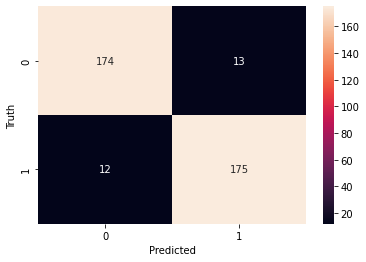

In [31]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [32]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       187
           1       0.93      0.94      0.93       187

    accuracy                           0.93       374
   macro avg       0.93      0.93      0.93       374
weighted avg       0.93      0.93      0.93       374



In [33]:
#Inference
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.7383456 ],
       [0.80865544],
       [0.7751053 ],
       [0.2111765 ],
       [0.12093014]], dtype=float32)